# Error Analysis on validation set

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from src.datapipeline import Datapipeline
from src.model_selector import ModelSelector
from src.bilstmmodel import BiLSTMModel
from src.conv1dmodel import Conv1DModel
from src.postprocess import add_prediction_to_val_data

plt.style.use('seaborn')

In [2]:
with open("config/config.json", "r") as f:
    config = json.load(f)

# Read data
train_df = pd.read_csv(config["train_data_path"])

test_size = 0.25
random_state = 0
train_data, val_data = train_test_split(train_df, test_size=test_size, random_state=random_state, shuffle=True)

# Preprocess data
datapipeline = Datapipeline(config["max_sequence_len"], config["label_mapping"])
X_train, y_train = datapipeline.transform_train_data(train_data)
X_val, y_val = datapipeline.transform_test_data(val_data, is_validation=True)

# Build model and load trained weights
model = ModelSelector(config["model"], config["model_params"])
model = model.build_model()
model.load_weights(config["model_weights_path"])

# Predict on val
y_val_pred = model.predict(X_val)

In [3]:
val_data_with_pred = add_prediction_to_val_data(y_val_pred, val_data, config["label_mapping"])

c:\Users\vince\Desktop\encrypted_text_proj\src\postprocess.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data["pred_label"] = y_pred_label
c:\Users\vince\Desktop\encrypted_text_proj\src\postprocess.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data["pred_label"] = val_data["pred_label"].map(reverse_mapping)
c:\Users\vince\Desktop\encrypted_text_proj\src\postprocess.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [4]:
val_data_with_pred['is_correct'] = val_data_with_pred['label'] == val_data_with_pred['pred_label']

<ipython-input-4-7193dc8848ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data_with_pred['is_correct'] = val_data_with_pred['label'] == val_data_with_pred['pred_label']


In [5]:
np.mean(val_data_with_pred['is_correct'])

0.7420814479638009

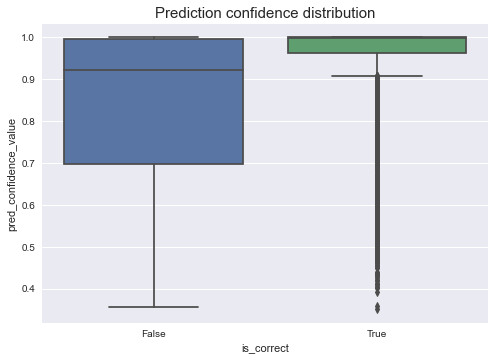

In [6]:
# Box plot comparison
sns.boxplot(data=val_data_with_pred, x='is_correct', y='pred_confidence_value')
plt.title('Prediction confidence distribution', fontsize=15)
plt.show()

In [7]:
# Summary statistics comparison
val_data_with_pred.groupby(['is_correct', 'label'])['pred_confidence_value'].describe()

count      mean       std       min       25%       50%  \
is_correct label                                                               
False      class_1   499.0  0.821685  0.182323  0.356701  0.682601  0.896297   
           class_2   180.0  0.811330  0.186629  0.357801  0.649037  0.867568   
           class_3   404.0  0.858945  0.176921  0.379694  0.742269  0.958500   
True       class_1  1027.0  0.902109  0.155385  0.358286  0.863195  0.991308   
           class_2  1139.0  0.966545  0.094050  0.403951  0.993990  0.999948   
           class_3   950.0  0.947608  0.119196  0.350778  0.980377  0.999791   

                         75%  max  
is_correct label                   
False      class_1  0.991321  1.0  
           class_2  0.990635  1.0  
           class_3  0.998794  1.0  
True       class_1  0.999954  1.0  
           class_2  1.000000  1.0  
           class_3  0.999999  1.0

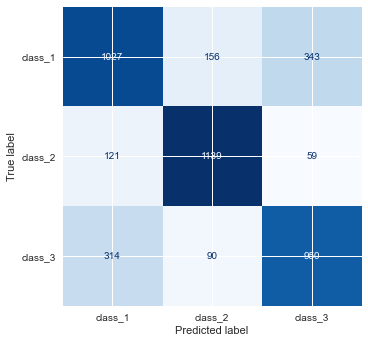

In [8]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay
cm = confusion_matrix(val_data_with_pred['label'], val_data_with_pred['pred_label'])
disp = ConfusionMatrixDisplay(cm, display_labels=sorted(['class_1','class_2','class_3']))
disp.plot(cmap='Blues',include_values=True, colorbar=False)

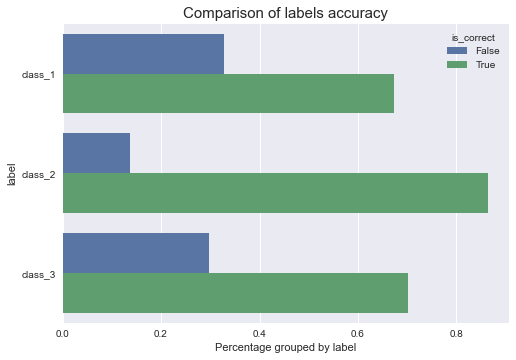

In [9]:
total = val_data_with_pred.groupby(['label', 'is_correct'])['feature'].count()
group_total = val_data_with_pred.groupby(['label'])['feature'].count()
temp = (total/ group_total).reset_index()

sns.barplot(data=temp, y='label', x='feature', hue='is_correct')
plt.title('Comparison of labels accuracy',fontsize=15)
plt.xlabel('Percentage grouped by label')
plt.show()

In [10]:
total/ group_total

label    is_correct
class_1  False         0.326999
         True          0.673001
class_2  False         0.136467
         True          0.863533
class_3  False         0.298375
         True          0.701625
Name: feature, dtype: float64